In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from layers import *
from rnn1 import *
from solver import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [35]:
raw = pickle.load(open("stories.pck", "rb"))
print len(raw), "examples"
print max([len(x) for x in raw]), "supporting facts and questions at most"
print max([len(y.split(' ')) for y in x for x in raw]), "words per sentence at most"

_null, _start, _query, _end = "<NULL>", "<Start>", "<Query>", "<End>"

words = [_null, _start, _query, _end] + [q for ex in raw for sent in ex for w in sent.split(' ') for q in w.split(',')]
words = sorted(set(words))
word_to_idx = {w:i for i,w in enumerate(words)}

print len(words), "total words"

T = 31 # longest story, 35 words unfolding
T2= 5

data = []
for ex in raw:
    sLen = 0
    while ex[sLen].find(',')==-1:
        sLen+=1
    supports = word_to_idx[_null] * np.ones(T, dtype=int)
    queries = word_to_idx[_null] * np.ones((len(ex)-sLen, T2), dtype=int)
    
    pos=0
    for idx, sent in enumerate(ex):
        if idx<sLen:
            sent = [word_to_idx[_start]] + [word_to_idx[x] for x in sent.split(' ')]
            supports[pos:pos+len(sent)+1] = sent + [word_to_idx[_end]]
            pos += len(sent)
        else:
            sent = sent.split(',')[0]
            sent = [word_to_idx[_query]] + [word_to_idx[x] for x in sent.split(' ')]
            sent = sent + [word_to_idx[_null]]*(T2-len(sent)-1) + [word_to_idx[_end]]#null pad the sentence
            queries[idx-sLen, :] = sent
    
    answers = np.asarray([word_to_idx[x.split(',')[1]] for x in ex[sLen:]]).reshape(len(ex)-sLen, 1)
    for i in xrange(queries.shape[0]):
        data.append(np.hstack((supports, queries[i,:], answers[i,:])))

data = np.asarray(data)
data_train = data[:-1000,:]
data_test = data[-1000:,:]
print data_train.shape

1000 examples
14 supporting facts and questions at most
5 words per sentence at most
159 total words
(3275, 37)


(Iteration 1 / 150) loss: 4.482038
(Iteration 11 / 150) loss: 2.433492
(Iteration 21 / 150) loss: 2.325440
(Iteration 31 / 150) loss: 1.823419
(Iteration 41 / 150) loss: 1.179898
(Iteration 51 / 150) loss: 0.688655
(Iteration 61 / 150) loss: 0.390618
(Iteration 71 / 150) loss: 0.201693
(Iteration 81 / 150) loss: 0.151589
(Iteration 91 / 150) loss: 0.098668
(Iteration 101 / 150) loss: 0.151300
(Iteration 111 / 150) loss: 0.069594
(Iteration 121 / 150) loss: 0.053710
(Iteration 131 / 150) loss: 0.037960
(Iteration 141 / 150) loss: 0.027944


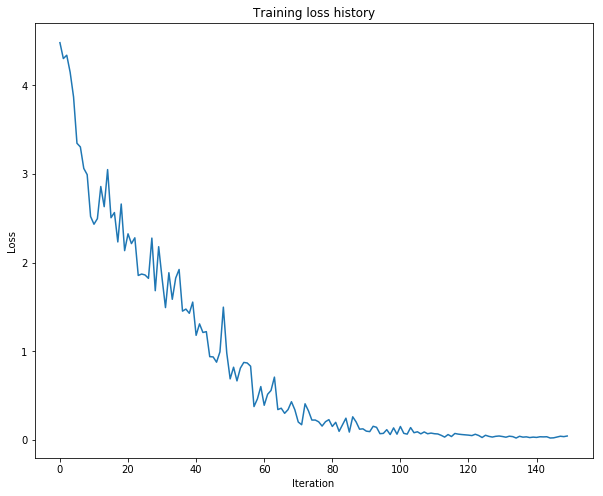

In [15]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=256, wordvec_dim=512)
solver = SeqNNSolver(model, data_train[:50],
           update_rule='adam',
           num_epochs=75,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [17]:
minibatch = data_train[:50]
print "Train:",
answ=model.loss(minibatch, sample=True)
print (answ==minibatch[:,-1]).mean()

minibatch = data_test[:50]
print "Test:",
answ=model.loss(minibatch, sample=True)
print (answ==minibatch[:,-1]).mean()

print "\n".join(" ".join([words[x] for x in data_train[0,:-T2-1]]).split(_start))
i=0
while np.all(data_train[0,:-T2-1]==data_train[i,:-T2-1]):
  print " ".join([words[x] for x in data_train[i,-T2-1:]])
  i=i+1

print
print "Other answers:"
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

Train: 1.0
Test: 0.02

 arif tershane 'a gitti . 
 aygul bahce 'a gitti . 
 aylin sigara 'yi tershane 'a tasidi . 
 abbas bolum 'a gitti . <End> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL>
<Query> aylin nerede ? <NULL> <NULL> <End> tershane
<Query> sigara nerede ? <NULL> <NULL> <End> tershane
<Query> aygul nerede ? <NULL> <NULL> <End> bahce
<Query> arif nerede ? <NULL> <NULL> <End> tershane
<Query> abbas nerede ? <NULL> <NULL> <End> bolum

Other answers:
okul amfi
servis mutfak
sira otobus
amfi amfi
sinif amfi
bahce kantin
tershane amfi
servis araba
tuvalet park
bahce okul
mutfak hastane
mutfak sinif
tuvalet sinif
tamirhane tershane
tuvalet sehpa
amfi tershane
mutfak sehpa
ev sehpa
ev bolum
servis dersane
tuvalet tamirhane
tuvalet dersane
tuvalet sehpa
tuvalet sandalye
sira sehpa
tuvalet sandalye
tuvalet kamyon
tuvalet hastane
hastane okul
tershane kamyon
bahce masa
hastane okul
tuvalet dersane
kamyon dersane
tuvalet sira
tershane m

(Iteration 1 / 6500) loss: 5.081163
(Iteration 11 / 6500) loss: 3.408903
(Iteration 21 / 6500) loss: 3.553241
(Iteration 31 / 6500) loss: 3.691982
(Iteration 41 / 6500) loss: 3.472588
(Iteration 51 / 6500) loss: 3.408628
(Iteration 61 / 6500) loss: 3.459859
(Iteration 71 / 6500) loss: 3.322526
(Iteration 81 / 6500) loss: 3.423279
(Iteration 91 / 6500) loss: 3.698760
(Iteration 101 / 6500) loss: 3.478104
(Iteration 111 / 6500) loss: 3.472032
(Iteration 121 / 6500) loss: 3.394311
(Iteration 131 / 6500) loss: 3.434845
(Iteration 141 / 6500) loss: 3.482549
(Iteration 151 / 6500) loss: 3.291287
(Iteration 161 / 6500) loss: 3.233374
(Iteration 171 / 6500) loss: 3.203009
(Iteration 181 / 6500) loss: 3.214114
(Iteration 191 / 6500) loss: 3.434284
(Iteration 201 / 6500) loss: 3.508972
(Iteration 211 / 6500) loss: 3.209338
(Iteration 221 / 6500) loss: 3.244726
(Iteration 231 / 6500) loss: 3.227492
(Iteration 241 / 6500) loss: 3.182003
(Iteration 251 / 6500) loss: 3.369503
(Iteration 261 / 6500) 

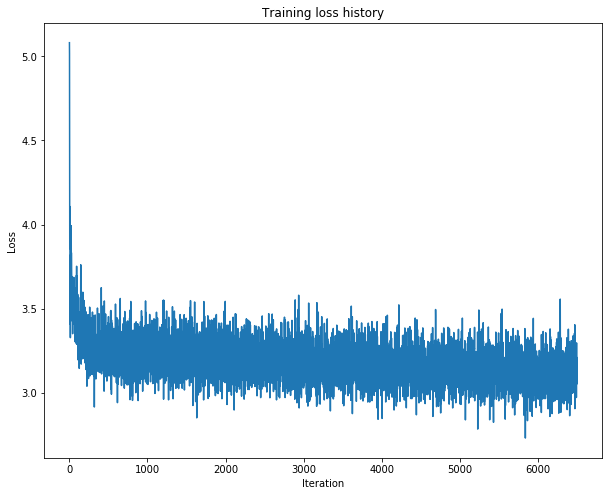

In [38]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=512, wordvec_dim=256)
solver = SeqNNSolver(model, data_train,
           update_rule='adam',
           num_epochs=100,
           batch_size=50,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [19]:
print "Train:",
answ=model.loss(data_train[:1000,:], sample=True)
print (answ==data_train[:1000,-1]).mean()
minibatch = data_train[:10]
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

print
print "Test:",
answ=model.loss(data_test[:1000], sample=True)
print (answ==data_test[:1000,-1]).mean()
minibatch = data_test[:10]
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

Train: 0.709
tershane tershane
tershane tershane
tershane bahce
tershane tershane
tershane bolum
amfi sinif
mutfak servis
mutfak mutfak
mutfak mutfak
mutfak mutfak

Test: 0.047
bolum amfi
labaratuvar mutfak
araba otobus
araba amfi
oda amfi
amfi kantin
sira amfi
masa araba
kamyon park
kamyon okul


(Iteration 1 / 150) loss: 5.059273
(Iteration 11 / 150) loss: 3.393621
(Iteration 21 / 150) loss: 2.451049
(Iteration 31 / 150) loss: 2.209528
(Iteration 41 / 150) loss: 1.664157
(Iteration 51 / 150) loss: 1.500286
(Iteration 61 / 150) loss: 0.786686
(Iteration 71 / 150) loss: 0.698852
(Iteration 81 / 150) loss: 0.318055
(Iteration 91 / 150) loss: 0.276624
(Iteration 101 / 150) loss: 0.135957
(Iteration 111 / 150) loss: 0.084413
(Iteration 121 / 150) loss: 0.076423
(Iteration 131 / 150) loss: 0.064472
(Iteration 141 / 150) loss: 0.053949


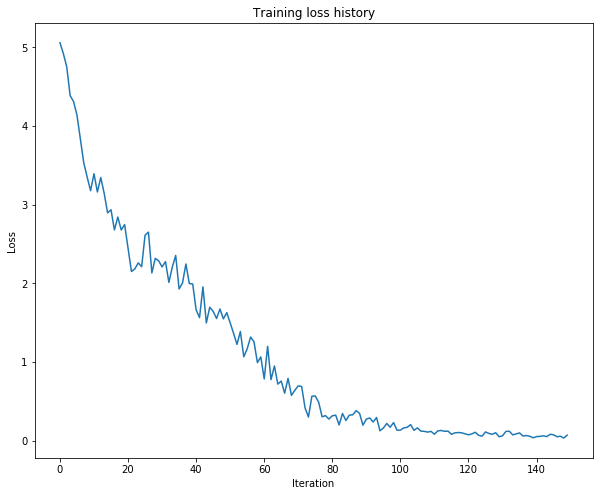

In [36]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=256, wordvec_dim=256)
solver = SeqNNSolver(model, data_train[:50],
           update_rule='adam',
           num_epochs=75,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()